In [73]:
#Se importan las clases.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [ ]:
#Directorio.
directorio = r"C:\Users\Juan\Documents\Digital House\Git Digital House\DHDS_IV\midi_stats_v3_drop_cols_.csv"

Análisis exploratorio - Pre-procesamiento

In [ ]:
#Se levanta el dataset.
data = pd.read_csv(directorio)

In [ ]:
#Se eliminan los valores nulos.
data = data.fillna(value = 0)

In [ ]:
#Se elimina registro que tiende a infinito.
data.drop(data[data.cant_pedales_seg > 9999999].index, inplace = True)

In [ ]:
#Redondeo de floats.
for col in data.loc[:, data.dtypes == np.float64].columns:
    data[col] = data[col].apply(lambda x: round(x, 4))

In [ ]:
#Visualización de columnas.
pd.options.display.max_columns = 20
#data.head(3)

In [ ]:
#data.Genero.value_counts()/data.shape[0]

In [ ]:
#Matrices de features y target.
x = data.drop(columns = ["Genero", "tema", "Grupo", "info_tracks", "Unnamed: 0"], axis = 1)
y = data["Genero"]

In [ ]:
#Columnas categóricas / numéricas.
categorical_columns = [col for col in x.columns if x[col].dtypes == 'object']
non_categorical_columns = [col for col in x.columns if col not in categorical_columns]

In [ ]:
#Código para el encoder.
categorical_columns = [col for col in x.columns if x[col].dtypes == 'object']
encoder_categories = []
for col in categorical_columns:    
    col_categories = x[col].unique()
    encoder_categories.append(col_categories)

In [ ]:
#División del dataset.
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify = y, random_state = 1)

In [ ]:
#Feature Engineering - columnas categóricas.
categorical_columns = [col for col in x.columns if x[col].dtypes == 'object']
encoder_categories = []
for col in categorical_columns:    
    col_categories = x[col].unique()
    encoder_categories.append(col_categories)
#encoder_categories

In [ ]:
#Encoder.
encoder = OneHotEncoder(categories = encoder_categories, sparse=False)
encoder = encoder.fit(X_train[categorical_columns])
X_train_encoded = encoder.transform(X_train[categorical_columns])
X_train_categorical = pd.DataFrame(X_train_encoded, columns = encoder.get_feature_names(categorical_columns))
X_test_encoded = encoder.transform(X_test[categorical_columns])
X_test_categorical = pd.DataFrame(X_test_encoded, columns = encoder.get_feature_names(categorical_columns))
#X_train_categorical.head(3)
#X_test_categorical.head(3)

In [ ]:
#Feature Engineering - columnas numéricas.
non_categorical_columns = [col for col in X_train.columns if col not in categorical_columns]
#non_categorical_columns

In [ ]:
#Estandarización X_train.
std_sclr = StandardScaler()
std_sclr_trained = std_sclr.fit(X_train[non_categorical_columns])
X_train_numerical = std_sclr_trained.transform(X_train[non_categorical_columns])
X_train_numerical_scaled = pd.DataFrame(X_train_numerical, columns = non_categorical_columns)
#X_train_numerical_scaled.head()

In [ ]:
#Estandarización X_test.
X_test_numerical = std_sclr_trained.transform(X_test[non_categorical_columns])
X_test_numerical_scaled = pd.DataFrame(X_test_numerical, columns = non_categorical_columns)
#X_test_numerical_scaled.head()

In [ ]:
#Concatenación de dataframes de entrenamiento.
X_train_transf = pd.concat([X_train_categorical, X_train_numerical_scaled], axis = 1)
#print(X_train_categorical.shape)
#print(X_train_numerical_scaled.shape)
#print(X_train_transf.shape)

In [ ]:
#Concatenación de dataframes de testeo.
X_test_transf = pd.concat([X_test_categorical, X_test_numerical_scaled], axis = 1)
#print(X_test_categorical.shape)
#print(X_test_numerical_scaled.shape)
#print(X_test_transf.shape)

Funciones de modelos

In [67]:
#Función para modelo sin GridsearchCV.
def model_no_GCV(model_instance, X_train, y_train, X_test, y_test):
    model_instance.fit(X_train, y_train)
    y_pred_train = model_instance.predict(X_train)
    y_pred_test = model_instance.predict(X_test)
    score_train = pd.DataFrame(classification_report(y_train, y_pred_train, output_dict = True)).transpose()
    score_test = pd.DataFrame(classification_report(y_test, y_pred_test, output_dict = True)).transpose()
    cm = confusion_matrix(y_test, y_pred_test)
    labels_gender = ['Classic Rock', 'Classical', 'Dance Techno', 'Forro', 'Hymns', 'Jazz', 'New-Age', 'Punk', 'Reggae', 'Samba & Bossa', 'Tango', 'Latina']
    ax = sns.heatmap(cm, annot = True, cmap = "Reds", fmt = "d", xticklabels = labels_gender, yticklabels = labels_gender)
    ax.set(xlabel = 'Predicho', ylabel = 'Reales')
    result = {'score_train' : [print('score_train'), score_train], 
              'score_test' : [print('score_test'), score_test], 
              'confusion_matrix' : [print('confusion_matrix'), ax]}
    return result

In [68]:
#Función para modelo con GridsearchCV.
def model_GCV(model_instance, X_train, y_train, X_test, y_test, gridsearch_params):
    folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
    gridsearch = GridSearchCV(model_instance, gridsearch_params, n_jobs = -1, cv = folds)    
    gridsearch.fit(X_train, y_train) 
    best_score = gridsearch.best_score_
    best_params = gridsearch.best_params_
    best_estimator = gridsearch.best_estimator_
    y_pred_train_grid = gridsearch.best_estimator_.predict(X_train)
    y_pred_test_grid = gridsearch.best_estimator_.predict(X_test)
    score_train_grid = pd.DataFrame(classification_report(y_train, y_pred_train_grid, output_dict = True)).transpose()
    score_test_grid = pd.DataFrame(classification_report(y_test, y_pred_test_grid, output_dict = True)).transpose()
    cm_grid = confusion_matrix(y_test, y_pred_test_grid)
    labels_gender = ['Classic Rock', 'Classical', 'Dance Techno', 'Forro', 'Hymns', 'Jazz', 'New-Age', 'Punk', 'Reggae', 'Samba & Bossa', 'Tango', 'Latina']
    ax_grid = sns.heatmap(cm_grid, annot = True, cmap = "Reds", fmt = "d", xticklabels = labels_gender, yticklabels = labels_gender)
    ax_grid.set(xlabel = 'Predicho', ylabel = 'Reales')
    result_grid = {'score_train_grid' : [print('score_train_grid'), score_train_grid], 
              'score_test_grid' : [print('score_test_grid'), score_test_grid], 
              'confusion_matrix_grid' : [print('confusion_matrix_grid'), ax_grid],
              'best_estimator' : best_estimator}
    return result_grid

In [69]:
#Función para feature importance.
def feature_importance_DataFrame(model_instance, X_train, y_train):
    model_instance.fit(X_train, y_train)
    feature_names = X_train.columns
    feature_importance = model_instance.feature_importances_
    importance = pd.DataFrame({'feature_names' : feature_names, 'feature_importance' : feature_importance})
    importance.sort_values(by = 'feature_importance', axis = 0, ascending = False, inplace = True)
    result_feature_importance_DataFrame = importance.head(20)
    return result_feature_importance_DataFrame

In [70]:
#Función para feature importance.
def feature_importance_plot(model_instance, X_train, y_train):
    model_instance.fit(X_train, y_train)
    feature_names = X_train.columns
    feature_importance = model_instance.feature_importances_
    importance = pd.DataFrame({'feature_names' : feature_names, 'feature_importance' : feature_importance})
    importance.sort_values(by = 'feature_importance', axis = 0, ascending = False, inplace = True)
    plt.figure()
    plt.title("Importancia de los features")
    x_values = range(importance.head(20).shape[0])
    y_values = importance.head(20).feature_importance
    plt.bar(x_values, y_values, color = "r")
    plt.xticks(x_values, importance.head(20).feature_names, rotation = 90)
    result_feature_importance_plot = plt.show()
    return result_feature_importance_plot

In [71]:
#Función undersampling.
def model_no_GCV_undersampling(model_instance, X_train, y_train, X_test, y_test):
    undersampler = RandomUnderSampler(sampling_strategy = 'majority')
    X_train_us, y_train_us = undersampler.fit_resample(X_train, y_train)
    model_instance.fit(X_train_us, y_train_us)
    y_pred_train_us = model_instance.predict(X_train_us)
    y_pred_test_us = model_instance.predict(X_test)
    score_train_us = pd.DataFrame(classification_report(y_train_us, y_pred_train_us, output_dict = True)).transpose()
    score_test_us = pd.DataFrame(classification_report(y_test, y_pred_test_us, output_dict = True)).transpose()
    cm_us = confusion_matrix(y_test, y_pred_test_us)
    labels_gender = ['Classic Rock', 'Classical', 'Dance Techno', 'Forro', 'Hymns', 'Jazz', 'New-Age', 'Punk', 'Reggae', 'Samba & Bossa', 'Tango', 'Latina']
    ax_us = sns.heatmap(cm_us, annot = True, cmap = "Reds", fmt = "d", xticklabels = labels_gender, yticklabels = labels_gender)
    ax_us.set(xlabel = 'Predicho', ylabel = 'Reales')
    result_us = {'score_train_us' : [print('score_train_us'), score_train_us], 
              'score_test_us' : [print('score_test_us'), score_test_us], 
              'confusion_matrix_us' : [print('confusion_matrix_us'), ax_us]}
    return result_us

In [72]:
#Función oversampling.
def model_no_GCV_oversampling(model_instance, X_train, y_train, X_test, y_test):
    oversampler = RandomOverSampler(sampling_strategy = 'minority')
    X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)
    model_instance.fit(X_train_os, y_train_os)
    y_pred_train_os = model_instance.predict(X_train_os)
    y_pred_test_os = model_instance.predict(X_test)
    score_train_os = pd.DataFrame(classification_report(y_train_os, y_pred_train_os, output_dict = True)).transpose()
    score_test_os = pd.DataFrame(classification_report(y_test, y_pred_test_os, output_dict = True)).transpose()
    cm_os = confusion_matrix(y_test, y_pred_test_os)
    labels_gender = ['Classic Rock', 'Classical', 'Dance Techno', 'Forro', 'Hymns', 'Jazz', 'New-Age', 'Punk', 'Reggae', 'Samba & Bossa', 'Tango', 'Latina']
    ax_os = sns.heatmap(cm_os, annot = True, cmap = "Reds", fmt = "d", xticklabels = labels_gender, yticklabels = labels_gender)
    ax_os.set(xlabel = 'Predicho', ylabel = 'Reales')
    result_os = {'score_train_os' : [print('score_train_os'), score_train_os], 
              'score_test_os' : [print('score_test_os'), score_test_os], 
              'confusion_matrix_os' : [print('confusion_matrix_os'), ax_os]}
    return result_os

In [82]:
#Función select k best.
def select_kbest(X_train, y_train, f):
    feat_selector = SelectKBest(f_classif, k = f)    
    fitting = feat_selector.fit(X_train, y_train)
    feat_scores = pd.DataFrame()
    feat_scores["Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = X_train.columns
    result_feat_scores = feat_scores.sort_values("Score", ascending = False).head(50)
    return result_feat_scores

In [93]:
#Función RFECV.
def RFECV_features(model_instance, X_train, y_train, X_test, y_test):
    skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
    selector = RFECV(model_instance, step = 1, cv = skf, verbose = 0, n_jobs = -1)
    selector.fit(X_train, y_train)
    X_train_reduced = X_train.loc[:, selector.support_]
    X_test_reduced = X_test.loc[:, selector.support_]
    model_instance.fit(X_train, y_train)
    y_pred_train_rfecv = model_instance.predict(X_train)
    y_pred_test_rfecv = model_instance.predict(X_test)
    score_train_rfecv = pd.DataFrame(classification_report(y_train, y_pred_train_rfecv, output_dict = True)).transpose()
    score_test_rfecv = pd.DataFrame(classification_report(y_test, y_pred_test_rfecv, output_dict = True)).transpose()
    cm_rfecv = confusion_matrix(y_test, y_pred_test_rfecv)
    labels_gender = ['Classic Rock', 'Classical', 'Dance Techno', 'Forro', 'Hymns', 'Jazz', 'New-Age', 'Punk', 'Reggae', 'Samba & Bossa', 'Tango', 'Latina']
    ax_rfecv = sns.heatmap(cm_rfecv, annot = True, cmap = "Reds", fmt = "d", xticklabels = labels_gender, yticklabels = labels_gender)
    ax_rfecv.set(xlabel = 'Predicho', ylabel = 'Reales')
    result_rfecv = {'score_train_rfecv' : [print('score_train_rfecv'), score_train_rfecv], 
              'score_test_rfecv' : [print('score_test_rfecv'), score_test_rfecv], 
              'confusion_matrix_rfecv' : [print('confusion_matrix_rfecv'), ax_rfecv]}
    return result_rfecv

KNN

In [ ]:
#Modelo sin GridsearchCV.
knn_no_GCV = model_no_GCV(KNeighborsClassifier(n_neighbors = 2), X_train_transf, y_train, X_test_transf, y_test)
knn_no_GCV

In [ ]:
#Modelo con GridsearchCV.
knn_gridsearch_params = {'n_neighbors' : range(1, 5)}
knn_GCV = model_GCV(KNeighborsClassifier(n_neighbors = 2), X_train_transf, y_train, X_test_transf, y_test, knn_gridsearch_params)
knn_GCV

Logistic Regression

In [ ]:
#Modelo sin GridsearchCV.
lr_no_GCV = model_no_GCV(LogisticRegression(), X_train_transf, y_train, X_test_transf, y_test)
lr_no_GCV

In [ ]:
#Modelo con GridsearchCV.
lr_gridsearch_params = {'penalty' : ['l1', 'l2', None]}
lr_GCV = model_GCV(LogisticRegression(), X_train_transf, y_train, X_test_transf, y_test, lr_gridsearch_params)
lr_GCV

Naive Bayes

In [ ]:
#Modelo sin GridsearchCV.
nb_no_GCV = model_no_GCV(GaussianNB(), X_train_transf, y_train, X_test_transf, y_test)
nb_no_GCV

Decision Tree - Classic

In [ ]:
#Modelo sin GridsearchCV.
clftree_no_GCV = model_no_GCV(DecisionTreeClassifier(random_state = 42, criterion = "gini"), X_train_transf, y_train, X_test_transf, y_test)
clftree_no_GCV

In [ ]:
#Modelo con GridsearchCV.
clftree_gridsearch_params = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [5, 10, 15, None], 
                             "max_depth" : [1, 2, 3, 4, 5, 6, 8, 9, 10, None], "min_samples_split" : [2, 3, None]}
clftree_GCV = model_GCV(DecisionTreeClassifier(random_state = 42, criterion = "gini"), 
                        X_train_transf, y_train, X_test_transf, y_test, clftree_gridsearch_params)
clftree_GCV

In [ ]:
#Feature importance DataFrame.
clftree_feature_importance_DataFrame = feature_importance_DataFrame(DecisionTreeClassifier(criterion = 'entropy', 
                                                                                           max_depth = 8, min_samples_leaf = 5, random_state = 42), 
                                                                    X_train_transf, y_train)
clftree_feature_importance_DataFrame

In [ ]:
#Feature importance plot.
clftree_feature_importance_plot = feature_importance_plot(DecisionTreeClassifier(criterion = 'entropy', 
                                                                                           max_depth = 8, min_samples_leaf = 5, random_state = 42), 
                                                                    X_train_transf, y_train)
clftree_feature_importance_plot

In [ ]:
#Modelo undersampling sin GridsearchCV.
clftree_no_GCV_undersampling = model_no_GCV_undersampling(DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, min_samples_leaf = 5, 
                                                                                 random_state = 42), X_train_transf, y_train, X_test_transf, y_test)
clftree_no_GCV_undersampling

In [ ]:
#Modelo oversampling sin GridsearchCV.
clftree_no_GCV_oversampling = model_no_GCV_oversampling(DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, min_samples_leaf = 5, 
                                                                                 random_state = 42), X_train_transf, y_train, X_test_transf, y_test)
clftree_no_GCV_oversampling

C:\Users\Juan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score_train_rfecv
score_test_rfecv
confusion_matrix_rfecv


{'score_train_rfecv': [None,
                precision    recall  f1-score      support
  ClassicRock    0.907968  0.967105  0.936604  1520.000000
  Classical      0.961435  0.989843  0.975432  1083.000000
  Dance_Techno   0.000000  0.000000  0.000000    16.000000
  Forro          0.000000  0.000000  0.000000     5.000000
  Hymns          0.995798  0.979339  0.987500   242.000000
  Jazz           0.961864  0.965957  0.963907   235.000000
  NEW-AGE        0.721805  0.755906  0.738462   127.000000
  Punk           0.891304  0.706897  0.788462    58.000000
  REGGAE         0.727273  0.250000  0.372093    32.000000
  Samba&Bossa    0.843750  0.519231  0.642857    52.000000
  TANGO          0.956522  0.745763  0.838095    59.000000
  latina         0.763514  0.579487  0.658892   195.000000
  accuracy       0.920254  0.920254  0.920254     0.920254
  macro avg      0.727603  0.621627  0.658525  3624.000000
  weighted avg   0.911755  0.920254  0.912888  3624.000000],
 'score_test_rfecv': [Non

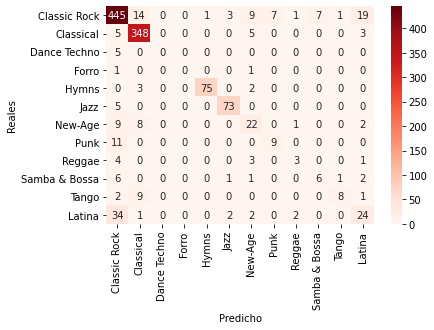

In [94]:
clftree_RFECV = RFECV_features(DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, min_samples_leaf = 5, random_state = 42), 
                               X_train_transf, y_train, X_test_transf, y_test)
clftree_RFECV